#Prerequisites

In [ ]:
!pip install transformers
!pip install torch
!pip install bertopic
!pip install openai
!pip install pinecone-client

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from transformers import BertTokenizer, BertModel
import pinecone
import torch

#Pinecone Data Access

In [ ]:
pinecone.init(api_key="", environment="")

indices = pinecone.list_indexes()
print(indices)
index = pinecone.Index('mindnews')
stats = index.describe_index_stats()
print(stats)

['mindnews']
{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}


In [ ]:
#Retrieve a sample of given size for the clsutering analysis
sample_size = 500
query_data = index.query(
    vector=[0] * 768,
    top_k=sample_size,
    include_metadata=True,
    include_values=True
)['matches']

In [ ]:
data = {
    "id": [],
    "values": [],
    "title": [],
    "userId": [],
    "abstract": [],
    "category": [],
    "subcategory": [],
}

for item in query_data:
  data["id"].append(item["id"])
  data["values"].append(item["values"])
  data["title"].append(item["metadata"]["title"])
  data["userId"].append(item["metadata"]["userId"])
  data["abstract"].append(item["metadata"]["abstract"])
  data["category"].append(item["metadata"]["category"])
  data["subcategory"].append(item["metadata"]["subcategory"])

user_interaction_data = pd.DataFrame(data)
user_interaction_data

,id,values,title,userId,abstract,category,subcategory
0,166,"[0.143954322, 0.0280617047, 0.210680738, -0.00...",NFL world reacts to officials handing Packers ...,U10235,It's a regular occurrence for NFL officiating ...,tv sports autos entertainment news finance,autosownership newsopinion celebrity autossuvs...
1,216,"[0.049479425, -0.141844183, 0.397118777, 0.071...",Snow crab sells for record price in Japan Pors...,U10315,"A ""five shining star"" snow crab was auctioned ...",tv foodanddrink entertainment news finance health,wellness newspolitics celebrity entertainment-...
2,303,"[-0.051924292, 0.00330238626, 0.340338886, 0.0...","Missing West Point cadet found dead, officials...",U10447,A U.S. Military Academy cadet who vanished las...,lifestyle sports autos travel news finance,newscrime travelnews newsworld newsus lifestyl...
3,224,"[-0.151905745, -0.0914751366, 0.267368704, 0.1...","Marlboro Man Bob Norris dies at 90, having rep...",U10327,"Robert ""Bob"" Norris, who played the iconic Mar...",finance tv,finance-companies tv-celebrity
4,748,"[0.0389661081, -0.206793621, 0.357469738, 0.10...",Stars Who Served in the Military 9 Amazing Tra...,U11224,"Adam Driver, Jeff Bridges, Ice-T and more star...",lifestyle sports news autos entertainment musi...,finance-real-estate newsworld entertainment-ce...
...,...,...,...,...,...,...,...
495,344,"[-0.0386663377, -0.0631292462, 0.233211607, 0....","'Wheel Of Fortune' Guest Delivers Hilarious, O...",U10515,"We'd like to solve the puzzle, Pat: Blair Davi...",tv foodanddrink travel entertainment news health,fitness celebrity newsus traveltripideas resta...
496,721,"[-0.108103946, -0.184339091, 0.144649297, -0.0...",'One in a million' deer captured on camera in ...,U1116,Retired Michigan lawmaker and amateur photogra...,music news movies,newscrime newspolitics newsus music-celebrity ...
497,210,"[-0.138285682, 0.0416786857, 0.483318418, 0.02...",'One in a million' deer captured on camera in ...,U10306,Retired Michigan lawmaker and amateur photogra...,lifestyle music foodanddrink entertainment news,newscrime newsus humor recipes quickandeasy li...
498,170,"[0.0302877221, -0.163613409, 0.408969074, -0.0...",Here Are the Biggest Deals We're Anticipating ...,U10241,The Black Friday deals for 2019 have already b...,lifestyle tv sports news health,newspolitics shop-holidays advice humor lifest...


#BERTopic clustering and mining with OpenAI representation

In [ ]:
from bertopic import BERTopic
from bertopic.representation import OpenAI
import os
import openai
# Fine-tune topic representations with GPT
openai.api_key = "sk-"

In [ ]:
text = user_interaction_data.title.tolist()

In [ ]:
#representation_model = KeyBERTInspired()
representation_model = OpenAI(model="gpt-3.5-turbo-0613", chat=True)
topic_model = BERTopic(representation_model=representation_model)
topics, _ = topic_model.fit_transform(text)
topic_info = topic_model.get_topic_info()
print(f"topic_info {topic_info}")

topic_info     Topic  Count                                               Name  \
0      -1    271  -1_Kiss cancelation, deer sighting, Harry and ...   
1       0     30       0_Celebrity news and transformations in 2019   
2       1     30  1_Royal family news surrounding Prince Harry a...   
3       2     29  2_Former Detroit Lions star Charles Rogers, de...   
4       3     23                3_News articles on various subjects   
5       4     19     4_LASIK eye surgery and NFL winners and losers   
6       5     19  5_Meghan McCain confronts Trump Jr. and family...   
7       6     17                      6_Black Friday Deals and News   
8       7     16  7_"One in a million" deer captured on camera i...   
9       8     13  8_Latest News about Halle Berry's 6-Pack Abs a...   
10      9     11   9_Bob Kingsley, Country Radio Legend, Dead at 80   
11     10     11  10_College gymnast dies following training acc...   
12     11     11  11_Off-the-rails introduction on 'Wheel of For..

In [ ]:
topic_info[['Topic','Name','Representation','Representative_Docs']]

,Topic,Name,Representation,Representative_Docs
0,-1,"-1_Kiss cancelation, deer sighting, Harry and ...","[Kiss cancelation, deer sighting, Harry and Me...",[Kiss Cancel 'End of the Road' Tour of Austral...
1,0,0_Celebrity news and transformations in 2019,[Celebrity news and transformations in 2019],[The Giudice family reunites and more ICYMI ce...
2,1,1_Royal family news surrounding Prince Harry a...,[Royal family news surrounding Prince Harry an...,[Shakira reflects on her career-threatening in...
3,2,"2_Former Detroit Lions star Charles Rogers, de...","[Former Detroit Lions star Charles Rogers, dea...",[Former NFL lineman Justin Bannan arrested for...
4,3,3_News articles on various subjects,[News articles on various subjects],['It's not over': Sarah Palin says she is figh...
5,4,4_LASIK eye surgery and NFL winners and losers,[LASIK eye surgery and NFL winners and losers],"[NFL winners, losers: Cowboys need to rebound,..."
6,5,5_Meghan McCain confronts Trump Jr. and family...,"[Meghan McCain confronts Trump Jr. and family,...",[Meghan McCain confronts Trump Jr.: 'You and y...
7,6,6_Black Friday Deals and News,[Black Friday Deals and News],[Here Are the Biggest Deals We're Anticipating...
8,7,"7_""One in a million"" deer captured on camera i...","[""One in a million"" deer captured on camera in...",[Browns cut WR Antonio Callaway hours before k...
9,8,8_Latest News about Halle Berry's 6-Pack Abs a...,[Latest News about Halle Berry's 6-Pack Abs an...,[Dean Foods files for bankruptcy 37 Years Afte...


In [ ]:
topic_info['Representative_Docs_Summary']= topic_info.apply(lambda row: ', '.join([str(sublist) for sublist in row['Representative_Docs']]), axis=1)
for index, row  in topic_info.iterrows():
  print({row['Topic']},":\n", {row['Name']}," :\n ", row['Representation'])
  #summary = " . ".join(row['Representative_Docs'])
  summary = row['Representative_Docs_Summary']
  print(f"{len(summary)} : {summary}")


{-1} :
 {"-1_Kiss cancelation, deer sighting, Harry and Meghan's baby photo"}  :
  ["Kiss cancelation, deer sighting, Harry and Meghan's baby photo"]
2331 : Kiss Cancel 'End of the Road' Tour of Australia and New Zealand Due to Illness NFL world reacts to officials handing Packers win over Lions 'The face of heroin': Mom shares haunting before and after pics of addiction The Amelia Earhart Mystery Stays Down in the Deep The Last McDonald's Burger in Iceland Just Turned 10. It's Still in Perfect Condition. Family of toddler who fell from cruise ship 'utterly crushed' after grandfather charged For the first time ever, a US cheese is named best in the world Navy Submarine, Missing for 75 Years, Is Found Off Okinawa 'Priceless' finds that turned out to be worthless Goats Munching on Vegetation Helped Save the Reagan Presidential Library in California Wildfire, 'One in a million' deer captured on camera in Michigan woods Prince Harry and Meghan Markle just shared a never-before-seen photo o

#OpenAI driven Topic Labelling

In [ ]:
system_prompt = """You are a data analyst looking through the summary of various news articles that users read. You read the user's message and genrates inherent topics that they are interested in.
Come up with maximum of 5 topics"""
sys_messages = [
        {"role": "system", "content": f"{system_prompt}"}]

In [ ]:
topic_clusters = []
for index, row in topic_info.iterrows():
  #print({row['Topic']},":\n", {row['Name']}," :\n ", row['Representation'])
  #summary = " . ".join(row['Representative_Docs'])
  sum = row['Representative_Docs_Summary']
  messages = sys_messages.copy()
  messages.append({"role": "user", "content": sum})
  #print(messages)

  response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0613",
        messages=messages,
        temperature=0.8,
        max_tokens=150,
        n=1,
        stop=None,
    )
  generated_topics = response.choices[0]['message']['content']
  print(generated_topics)
  print("************")
  topic = {"topic":row['Topic'],"inherent_interests":generated_topics}
  topic_clusters.append(topic)


1. Music: Kiss cancel 'End of the Road' tour of Australia and New Zealand due to illness
2. Sports: NFL world reacts to officials handing Packers win over Lions
3. Addiction: 'The face of heroin': Mom shares haunting before and after pics of addiction
4. History and Mystery: The Amelia Earhart Mystery Stays Down in the Deep
5. Food: The Last McDonald's Burger in Iceland Just Turned 10. It's Still in Perfect Condition.
************
1. Celebrity news and updates
2. Tragic events and accidents
3. Health and personal struggles of celebrities
4. Fashion and beauty transformations
5. Social and cultural issues surrounding celebrities
************
1. Royal Family News (e.g. Prince Harry, Meghan Markle, Prince Charles)
2. Celebrity News (e.g. Shakira, Jennifer Aniston, Jennifer Lopez)
3. Fashion and Style (e.g. Stella McCartney, Meghan Markle's Instagram post)
4. Health and Wellness (e.g. Marcia Cross' anal cancer, Meghan Markle's post-baby body)
5. General News (e.g. University of Florida stu

In [ ]:
topic_clusters

[{'topic': -1,
  'inherent_interests': "1. Music: Kiss cancel 'End of the Road' tour of Australia and New Zealand due to illness\n2. Sports: NFL world reacts to officials handing Packers win over Lions\n3. Addiction: 'The face of heroin': Mom shares haunting before and after pics of addiction\n4. History and Mystery: The Amelia Earhart Mystery Stays Down in the Deep\n5. Food: The Last McDonald's Burger in Iceland Just Turned 10. It's Still in Perfect Condition."},
 {'topic': 0,
  'inherent_interests': '1. Celebrity news and updates\n2. Tragic events and accidents\n3. Health and personal struggles of celebrities\n4. Fashion and beauty transformations\n5. Social and cultural issues surrounding celebrities'},
 {'topic': 1,
  'inherent_interests': "1. Royal Family News (e.g. Prince Harry, Meghan Markle, Prince Charles)\n2. Celebrity News (e.g. Shakira, Jennifer Aniston, Jennifer Lopez)\n3. Fashion and Style (e.g. Stella McCartney, Meghan Markle's Instagram post)\n4. Health and Wellness (e.

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

def get_wordcloud_for_user(recommendations):

    stopwords = set(STOPWORDS).union([np.nan, 'NaN', 'S'])

    wordcloud = WordCloud(
                   max_words=50000,
                   min_font_size =12,
                   max_font_size=50,
                   relative_scaling = 0.9,
                   stopwords=set(STOPWORDS),
                   normalize_plurals= True
    )
    print(recommendations)
    clean_titles = [word for line in recommendations.split("\n") for word in line.split()]
    title_wordcloud = wordcloud.generate(' '.join(clean_titles))

    plt.imshow(title_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#Inference Samples

1. Celebrity news and updates
2. Tragic events and accidents
3. Health and personal struggles of celebrities
4. Fashion and beauty transformations
5. Social and cultural issues surrounding celebrities


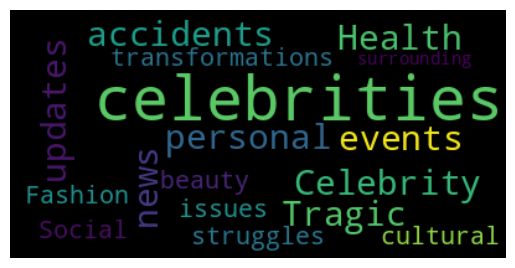

In [ ]:
#Let us explore mined interests for couple of clusters
get_wordcloud_for_user(topic_clusters[1]['inherent_interests'])

1. NFL news (Former NFL lineman Justin Bannan arrested for attempted murder, Charles Rogers, former Michigan State football, Detroit Lions star, dead at 38, NFL world reacts to officials handing Packers win over Lions)
2. Celebrity news (Prince Harry and Meghan Markle sharing a never-before-seen photo of baby Archie with his 'Grandpa' Prince Charles, Ruth Bader Ginsburg missing court due to illness, Kevin Spacey won't be charged in sexual assault case after accuser dies, Former Fox News hosts want out of non-disclosure agreements)
3. Legal news (Joe Biden reportedly denied Communion at a South Carolina church because of his stance on abortion, Mitch McConnell snubbed by Elijah Cummings' pallbearer in handshake


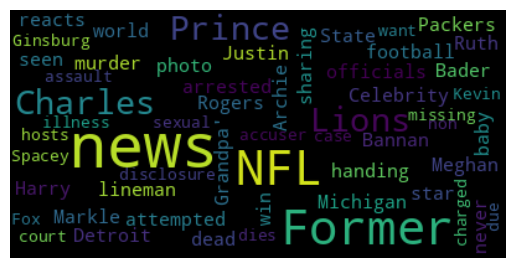

In [ ]:
get_wordcloud_for_user(topic_clusters[3]['inherent_interests'])

In [ ]:
doc_info = topic_model.get_document_info(text)
doc_info

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,NFL world reacts to officials handing Packers ...,4,4_LASIK eye surgery and NFL winners and losers,[LASIK eye surgery and NFL winners and losers],"[NFL winners, losers: Cowboys need to rebound,...",LASIK eye surgery and NFL winners and losers,1.000000,False
1,Snow crab sells for record price in Japan Pors...,-1,"-1_Kiss cancelation, deer sighting, Harry and ...","[Kiss cancelation, deer sighting, Harry and Me...",[Kiss Cancel 'End of the Road' Tour of Austral...,"Kiss cancelation, deer sighting, Harry and Meg...",0.000000,False
2,"Missing West Point cadet found dead, officials...",-1,"-1_Kiss cancelation, deer sighting, Harry and ...","[Kiss cancelation, deer sighting, Harry and Me...",[Kiss Cancel 'End of the Road' Tour of Austral...,"Kiss cancelation, deer sighting, Harry and Meg...",0.000000,False
3,"Marlboro Man Bob Norris dies at 90, having rep...",-1,"-1_Kiss cancelation, deer sighting, Harry and ...","[Kiss cancelation, deer sighting, Harry and Me...",[Kiss Cancel 'End of the Road' Tour of Austral...,"Kiss cancelation, deer sighting, Harry and Meg...",0.000000,False
4,Stars Who Served in the Military 9 Amazing Tra...,-1,"-1_Kiss cancelation, deer sighting, Harry and ...","[Kiss cancelation, deer sighting, Harry and Me...",[Kiss Cancel 'End of the Road' Tour of Austral...,"Kiss cancelation, deer sighting, Harry and Meg...",0.000000,False
...,...,...,...,...,...,...,...,...
495,"'Wheel Of Fortune' Guest Delivers Hilarious, O...",11,11_Off-the-rails introduction on 'Wheel of For...,[Off-the-rails introduction on 'Wheel of Fortu...,[Bartenders share 13 things they'd love to tel...,Off-the-rails introduction on 'Wheel of Fortun...,1.000000,False
496,'One in a million' deer captured on camera in ...,7,"7_""One in a million"" deer captured on camera i...","[""One in a million"" deer captured on camera in...",[Browns cut WR Antonio Callaway hours before k...,"""One in a million"" deer captured on camera in ...",1.000000,False
497,'One in a million' deer captured on camera in ...,-1,"-1_Kiss cancelation, deer sighting, Harry and ...","[Kiss cancelation, deer sighting, Harry and Me...",[Kiss Cancel 'End of the Road' Tour of Austral...,"Kiss cancelation, deer sighting, Harry and Meg...",0.000000,True
498,Here Are the Biggest Deals We're Anticipating ...,6,6_Black Friday Deals and News,[Black Friday Deals and News],[Here Are the Biggest Deals We're Anticipating...,Black Friday Deals and News,0.894364,False


#Comparison of Topic tags (explicit context) vs Generated Interests (implicit context)

In [47]:
from IPython.display import display, Markdown

def contrast_topic_interests(document_index):
  #Original Data for the user
  user_data = user_interaction_data.iloc[document_index]

  #Bertopic representation for the user document
  doc_cluster_topic = doc_info.iloc[document_index]

  #Interets generated by GenAI
  topic_id = doc_cluster_topic['Topic']
  topic_tags = user_data['category'].split(" ")
  generated_interests = [data for data in topic_clusters if data['topic']==topic_id]
  #print(f"Tagged keywords : {user_data['category']}\nInferred interests :\n{generated_interests[0]['inherent_interests']}")
  display(Markdown(f"### Standard tagged keywords"))
  display(Markdown(f"#### {', '.join(topic_tags)}"))
  display(Markdown(f"### Inferred interests"))
  display(Markdown(f"{generated_interests[0]['inherent_interests']}"))



In [48]:
# Sampling user at index 88
contrast_topic_interests(88)

### Standard tagged keywords

#### news, sports

### Inferred interests

1. NFL football (winners, losers, rebounding, Patriots, Cowboys)
2. Entertainment (Wheel of Fortune, The Masked Singer, Grammy winner, hilarious introduction)
3. Food and desserts (National Dessert Day, free dessert, Wendy's, TGI Friday)
4. News and current events (impeachment, Ohio voters, LASIK eye surgery, officials, Christmas display)
5. Celebrity news (Prince Harry, Meghan Markle, baby Archie, Prince Charles, Michael Jordan, Felicity Huffman)

In [49]:
# Sampling user at index 205
contrast_topic_interests(205)

### Standard tagged keywords

#### lifestyle, music, sports, autos, movies, news, finance

### Inferred interests

1. Black Friday deals
2. Celebrity news and deaths (Charles Rogers, Laurel Griggs, Kevin Spacey)
3. Food and culinary (US cheese named best in the world, Thanksgiving dishes)
4. Legal cases and lawsuits (Kevin Spacey, gun manufacturer, Arby's)
5. Automotive news (Porsche crash, Toyota Supra modification)